In [21]:
%matplotlib ipympl
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
from impedance.visualization import plot_nyquist, plot_bode
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

In [34]:
#My written functions
def add_noise(z,err):
    #err is the relative SD from mean value
    z_with_noise=np.random.normal(np.real(z),err*np.abs(np.real(z)))+1j*np.random.normal(np.imag(z),err*np.abs(np.imag(z)))
    return z_with_noise

def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))
    
def give_xylim(zin,z0):
        zin_real=np.real(zin)
        zin_imag=np.imag(zin)

        z0_real=np.real(z0)
        z0_imag=np.imag(z0)

        max_0=np.maximum(np.max(z0_real),np.max(-z0_imag))
        max_in=np.maximum(np.max(zin_real),np.max(-zin_imag))

        xylim=np.maximum(max_0,max_in)
        return xylim

In [23]:
@element(num_params=5, units=["Ohm", "Ohm", "","F",""],overwrite=True)
def TLMtwoNew(p, f):
   
    omega = 2 * np.pi * np.array(f)
    R1, R2, delta1, Q, alpha = p[0], p[1], p[2], p[3], p[4]
    delta2=1-delta1
    k12=R2/R1
    CTotal1=Q
    CTotal2=Q
    wc1=1/(R1*CTotal1)
    wc2=1/(R2*CTotal2)
    S1=np.sqrt(omega*1j/wc1)
    S2=np.sqrt(omega*1j/wc2)
    C1=1/np.tanh(delta1*S1)
    C2=1/np.tanh(delta2*S2)

    Z=2*(R1)*(C1*C2*S1*k12+S2)/(S1*(C2*S1*k12+C1*S2))

    return Z

In [24]:
def plotter_and_saver(fitted_pm,pm_conf,input_pm,z_with_noise,freq,save_folder_name):
  
    R1_fit=fitted_pm[0]
    R2_fit=fitted_pm[1]
    delta_fit=fitted_pm[2]
    Q_fit=fitted_pm[3]
    alpha_fit=fitted_pm[4]

    R1_in=input_pm[0]
    R2_in=input_pm[1]
    delta_in=input_pm[2]
    Q_in=input_pm[3]
    alpha_in=input_pm[4]

    circuit_in=CustomCircuit(initial_guess=[R1_in,R2_in,Q_in,delta_in],circuit='TLMtwoNew_0')
    z_in_as_per_pm=circuit_in.predict(freq)

    z_with_noise=z_with_noise          #final input data with noise

    circuit_fit=CustomCircuit(initial_guess=[R1_fit,R2_fit,Q_fit,delta_fit],circuit='TLMtwoNew_0')
    z_fit=circuit_fit.predict(freq)

    linewidth=1
    ticksize=6
    color_actual="green"
    color_noise="red"
    color_fitted="blue"

    fig = plt.figure(f"Results at δ={delta_in}")
    fig.set_size_inches(10,6)
    
    ax1= fig.add_subplot(2,3,2)

    ax1.plot([0,delta_in,delta_in,1],[R1_in,R1_in,R2_in,R2_in],linewidth=linewidth,color=color_actual,label="Actual")
    ax1.plot([0,delta_fit,delta_fit,1],[R1_fit,R1_fit,R2_fit,R2_fit],linewidth=linewidth,color=color_fitted,label="Fitted")
    ax1.tick_params(labelsize=ticksize)
    ax1.axvline(x=delta_in,ls="--",linewidth=0.6,color=color_actual)
    ax1.axvline(x=delta_fit,ls="--",linewidth=0.6,color=color_fitted)

    ax1.set_ylabel("R1 / R2 (Ω)")
    ax1.set_xlabel("δ")
    ax1.set_xmargin(0)
    ax1.legend()

    ax2=fig.add_subplot(2,3,3)
    z_with_noise_real=np.real(z_with_noise)
    z_with_noise_imag=np.imag(z_with_noise)

    z_in_real=np.real(z_in_as_per_pm)
    z_in_imag=np.imag(z_in_as_per_pm)

    z_fit_real=np.real(z_fit)
    z_fit_imag=np.imag(z_fit)

    max_in=np.maximum(np.max(z_in_real),np.max(-z_in_imag))
    max_with_noise=np.maximum(np.max(z_with_noise_real),np.max(-z_with_noise_imag))
    max_fit=np.maximum(np.max(z_fit_real),np.max(-z_fit_imag))
    
    x_y_lim=np.maximum(max_in,max_fit)

    ax2.set_xlim(-0.2*x_y_lim/1000,x_y_lim/1000)
    ax2.set_ylim(-0.2*x_y_lim/1000,x_y_lim/1000)

    #ax2.set_xlim(0,0.2)
    #ax2.set_ylim(0,0.2)

    plot_nyquist(z_in_as_per_pm/1000,ax=ax2,units="kΩ",labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(z_with_noise/1000,ax=ax2,units="kΩ",labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
    plot_nyquist(z_fit/1000,ax=ax2,units="kΩ",labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)

    ax2_inset=ax2.inset_axes(bounds=[0.4,0.4,0.5,0.5])
    plot_nyquist(z_in_as_per_pm/1000,ax=ax2_inset,units="kΩ",labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(z_with_noise/1000,ax=ax2_inset,units="kΩ",labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
    plot_nyquist(z_fit/1000,ax=ax2_inset,units="kΩ",labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)
    ax2_inset.set_xlim(0,np.maximum(np.max(z_in_real),np.max(z_fit_real))/1000)
    ax2_inset.set_ylim(0,np.maximum(np.max(z_in_real),np.max(z_fit_real))/1000)
    ax2_inset.set_xlabel("")
    ax2_inset.set_ylabel("")

    ax2.indicate_inset_zoom(ax2_inset)

    ax3a=fig.add_subplot(2,3,5)
    ax3b=fig.add_subplot(2,3,6)
    #ax3.set_xlim(0,1)
    #ax3.set_ylim(0,1)
    plot_bode(freq,z_in_as_per_pm/1000,axes=[ax3a,ax3b],units="kΩ",labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,z_with_noise/1000,axes=[ax3a,ax3b],units="kΩ",labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
    plot_bode(freq,z_fit/1000,axes=[ax3a,ax3b],units="kΩ",labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)

    fitted_pm[0]=np.around(fitted_pm[0],decimals=0,out=None)
    fitted_pm[1]=np.around(fitted_pm[1],decimals=0,out=None)
    fitted_pm[2]=np.around(fitted_pm[2],decimals=6,out=None)
    fitted_pm[3]=np.around(fitted_pm[3],decimals=4,out=None)

    pm_conf[0]=np.around(pm_conf[0],decimals=0,out=None)
    pm_conf[1]=np.around(pm_conf[1],decimals=0,out=None)
    pm_conf[2]=np.around(pm_conf[2],decimals=6,out=None)
    pm_conf[3]=np.around(pm_conf[3],decimals=4,out=None)


    data =np.array([input_pm,
            fitted_pm, (input_pm-fitted_pm)*100/(input_pm)])
    #cell_colors=[["blue","blue","blue","blue"],["green","green","green","green"]]
    
    
    ax4=fig.add_subplot(1,3,1)
    ax4.set_axis_off()
    pm_table=ax4.table(np.transpose(data),colLabels=["Actual","Fitted","% Error"],rowLabels=["R1","R2","Q","δ"],loc="center")
    pm_table.auto_set_font_size(False)
    pm_table.set_fontsize(10)

    plt.savefig(save_folder_name+f"//δ={delta_in}.png",format="png")
    #plt.show()
    plt.close()

In [25]:
freq = np.logspace(3,-3,num=100)

R1_R2_in_list=((1000,100),(502,500))
delta_to_be_tested=[0.01,0.1,0.2,0.5,0.8,0.9,0.99]
#delta_to_be_tested=[0.2]
Q_in=6.61e-4
noise=True

### intially guessed values of parameters for the model ### 
R1_gs=300
R2_gs=300
delta_gs=0.5
Q_gs=Q_in

### creating a circuit object for the initial guess model (for which parameters are just above defined) ###
circuit_guess=CustomCircuit(initial_guess=[R1_gs,R2_gs,Q_gs,delta_gs],circuit='TLMtwoNew_0')

for R1_R2 in R1_R2_in_list:

    R1_in=R1_R2[0]
    R2_in=R1_R2[1]
    
    name_of_folder_to_save_data=f"R1={R1_in} R2={R2_in} Q={Q_in} and diff delta"

    if os.path.exists(name_of_folder_to_save_data):
        shutil.rmtree(name_of_folder_to_save_data)
    os.mkdir(f"{name_of_folder_to_save_data}")

    for delta_in in delta_to_be_tested:
        circuit_in=CustomCircuit(initial_guess=[R1_in,R2_in,Q_in,delta_in],circuit='TLMtwoNew_0')
        pm_input=[R1_in,R2_in,Q_in,delta_in]
        z_from_circuit_in = circuit_in.predict(freq)
        if noise:
            for i in range(len(z_from_circuit_in)):
                z_real_new=np.random.normal(np.real(z_from_circuit_in[i]),np.abs(0.05*np.real(z_from_circuit_in[i])))
                z_imag_new=np.random.normal(np.imag(z_from_circuit_in[i]),np.abs(0.05*np.imag(z_from_circuit_in[i])))
                z_from_circuit_in[i]=z_real_new+1j*z_imag_new
                
        circuit_fitted=circuit_guess.fit(freq,z_from_circuit_in,bounds=(0,[np.inf,np.inf,np.inf,1]))
        pm_fitted=circuit_fitted.parameters_
        pm_conf=circuit_fitted.conf_
        plotter_and_saver(pm_fitted,pm_conf,pm_input,z_from_circuit_in,freq,name_of_folder_to_save_data)

C:\Users\Gaming\AppData\Local\Temp\ipykernel_18740\2013261161.py:15: RuntimeWarning: overflow encountered in tanh
  C2=1/np.tanh(delta2*S2)


In [26]:
freq = np.logspace(3,-3,num=100)
c0=CustomCircuit(initial_guess=[R1_in,R2_in,Q_in,delta_in],circuit='TLMtwoNew')
z0=c0.predict(freq)
z1=add_noise(z0,0.05)
z2=add_noise(z0,0.10)

In [27]:
param_guess=[1000,100,1e-4,0.6]
cg=CustomCircuit(initial_guess=param_guess,circuit="TLMtwoNew")
fit1=cg.fit(freq,z1,sigma=give_weights(z1,"unit"),bounds=(0,[np.inf,np.inf,np.inf,1]))
zfit1=fit1.predict(freq)


In [67]:
def plotter_for_two(freq,circuit0,zin,circuitg,wt):
    
    c0=circuit0
    z0=c0.predict(freq)
    
    cg=circuitg
    cf=cg.fit(freq,zin,sigma=give_weights(zin,wt),bounds=(0,[np.inf,np.inf,np.inf,1]))
    zf=cf.predict(freq)

    p0=c0.initial_guess
    R1_0=p0[0]
    R2_0=p0[1]
    Q_0=p0[2]
    delta_0=p0[3]

    pf=cf.parameters_
    R1_f=pf[0]
    R2_f=pf[1]
    Q_f=pf[2]
    delta_f=pf[3]

    linewidth=1
    ticksize=6
    color_actual="green"
    color_noise="red"
    color_fitted="blue"

    fig = plt.figure(f"Results at δ={delta_0}")
    fig.set_size_inches(10,6)
    
    #profile fit and profile original
    ax1= fig.add_subplot(2,3,2)
    ax1.plot([0,delta_0,delta_0,1],[R1_0,R1_0,R2_0,R2_0],linewidth=linewidth,color=color_actual,label="Actual")
    ax1.plot([0,delta_f,delta_f,1],[R1_f,R1_f,R2_f,R2_f],linewidth=linewidth,color=color_fitted,label="Fitted")
    ax1.tick_params(labelsize=ticksize)
    ax1.axvline(x=delta_0,ls="--",linewidth=0.6,color=color_actual)
    ax1.axvline(x=delta_f,ls="--",linewidth=0.6,color=color_fitted)
    ax1.set_ylabel("R1 / R2 (Ω)")
    ax1.set_xlabel("δ")
    ax1.set_xmargin(0)
    ax1.legend()

    xylim=max(give_xylim(zin,zf),give_xylim(zin,z0))

    if xylim%1000>=1:
        units="kΩ"
        factor=1000
    else:
        units="Ω"
        factor=1

    #nyquist plot 
    ax2=fig.add_subplot(2,3,3)
    ax2.set_xlim(-0.2*xylim/factor,xylim/factor)
    ax2.set_ylim(-0.2*xylim/factor,xylim/factor)
    plot_nyquist(z0/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zin/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
    plot_nyquist(zf/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)
    #inset_for_nyquist_plot
    ax2_inset=ax2.inset_axes(bounds=[0.4,0.4,0.5,0.5])
    plot_nyquist(z0/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zin/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
    plot_nyquist(zf/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)    
    xylim=give_xylim(np.real(z0),np.real(zf))
    ax2_inset.set_xlim(0,xylim/factor)
    ax2_inset.set_ylim(0,xylim/factor)
    ax2_inset.set_xlabel("")
    ax2_inset.set_ylabel("")
    ax2.indicate_inset_zoom(ax2_inset)

    #bode plots
    ax3a=fig.add_subplot(2,3,5)
    ax3b=fig.add_subplot(2,3,6)
    plot_bode(freq,z0/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,zin/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
    plot_bode(freq,zf/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)


    pf[0]=np.around(pf[0],decimals=0,out=None)
    pf[1]=np.around(pf[1],decimals=0,out=None)
    pf[2]=np.around(pf[2],decimals=6,out=None)
    pf[3]=np.around(pf[3],decimals=4,out=None)

    p0[0]=np.around(p0[0],decimals=0,out=None)
    p0[1]=np.around(p0[1],decimals=0,out=None)
    p0[2]=np.around(p0[2],decimals=6,out=None)
    p0[3]=np.around(p0[3],decimals=4,out=None)

    data =np.array([p0,pf, (p0-pf)*100/(p0)])
    #cell_colors=[["blue","blue","blue","blue"],["green","green","green","green"]]
    
    
    ax4=fig.add_subplot(1,3,1)
    ax4.set_axis_off()
    pm_table=ax4.table(np.transpose(data),colLabels=["Actual","Fitted","% Error"],rowLabels=["R1","R2","Q","δ"],loc="center")
    pm_table.auto_set_font_size(False)
    pm_table.set_fontsize(10)

    

In [ ]:
def plotter_for_two(freq,circuit0,zin,circuitg,wt):
    
    c0=circuit0
    z0=c0.predict(freq)
    
    cg=circuitg
    cf=cg.fit(freq,zin,sigma=give_weights(zin,wt),bounds=(0,[np.inf,np.inf,np.inf,1]))
    zf=cf.predict(freq)

    p0=c0.initial_guess
    R1_0=p0[0]
    R2_0=p0[1]
    Q_0=p0[2]
    delta_0=p0[3]

    pf=cf.parameters_
    R1_f=pf[0]
    R2_f=pf[1]
    Q_f=pf[2]
    delta_f=pf[3]

    linewidth=1
    ticksize=6
    color_actual="green"
    color_noise="red"
    color_fitted="blue"

    fig = plt.figure(f"Results at δ={delta_0}")
    fig.set_size_inches(10,6)
    
    #profile fit and profile original
    ax1= fig.add_subplot(2,3,2)
    ax1.plot([0,delta_0,delta_0,1],[R1_0,R1_0,R2_0,R2_0],linewidth=linewidth,color=color_actual,label="Actual")
    ax1.plot([0,delta_f,delta_f,1],[R1_f,R1_f,R2_f,R2_f],linewidth=linewidth,color=color_fitted,label="Fitted")
    ax1.tick_params(labelsize=ticksize)
    ax1.axvline(x=delta_0,ls="--",linewidth=0.6,color=color_actual)
    ax1.axvline(x=delta_f,ls="--",linewidth=0.6,color=color_fitted)
    ax1.set_ylabel("R1 / R2 (Ω)")
    ax1.set_xlabel("δ")
    ax1.set_xmargin(0)
    ax1.legend()

    xylim=max(give_xylim(zin,zf),give_xylim(zin,z0))

    if xylim%1000>=1:
        units="kΩ"
        factor=1000
    else:
        units="Ω"
        factor=1

    #nyquist plot 
    ax2=fig.add_subplot(2,3,3)
    ax2.set_xlim(-0.2*xylim/factor,xylim/factor)
    ax2.set_ylim(-0.2*xylim/factor,xylim/factor)
    plot_nyquist(z0/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zin/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
    plot_nyquist(zf/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)
    #inset_for_nyquist_plot
    ax2_inset=ax2.inset_axes(bounds=[0.4,0.4,0.5,0.5])
    plot_nyquist(z0/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zin/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
    plot_nyquist(zf/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)    
    xylim=give_xylim(np.real(z0),np.real(zf))
    ax2_inset.set_xlim(0,xylim/factor)
    ax2_inset.set_ylim(0,xylim/factor)
    ax2_inset.set_xlabel("")
    ax2_inset.set_ylabel("")
    ax2.indicate_inset_zoom(ax2_inset)

    #bode plots
    ax3a=fig.add_subplot(2,3,5)
    ax3b=fig.add_subplot(2,3,6)
    plot_bode(freq,z0/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,zin/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
    plot_bode(freq,zf/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)


    pf[0]=np.around(pf[0],decimals=0,out=None)
    pf[1]=np.around(pf[1],decimals=0,out=None)
    pf[2]=np.around(pf[2],decimals=6,out=None)
    pf[3]=np.around(pf[3],decimals=4,out=None)

    p0[0]=np.around(p0[0],decimals=0,out=None)
    p0[1]=np.around(p0[1],decimals=0,out=None)
    p0[2]=np.around(p0[2],decimals=6,out=None)
    p0[3]=np.around(p0[3],decimals=4,out=None)

    data =np.array([p0,pf, (p0-pf)*100/(p0)])
    #cell_colors=[["blue","blue","blue","blue"],["green","green","green","green"]]
    
    
    ax4=fig.add_subplot(1,3,1)
    ax4.set_axis_off()
    pm_table=ax4.table(np.transpose(data),colLabels=["Actual","Fitted","% Error"],rowLabels=["R1","R2","Q","δ"],loc="center")
    pm_table.auto_set_font_size(False)
    pm_table.set_fontsize(10)

    

c:\Users\Gaming\AppData\Local\Programs\Python\Python311\Lib\site-packages\impedance\models\circuits\circuits.py:145: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")


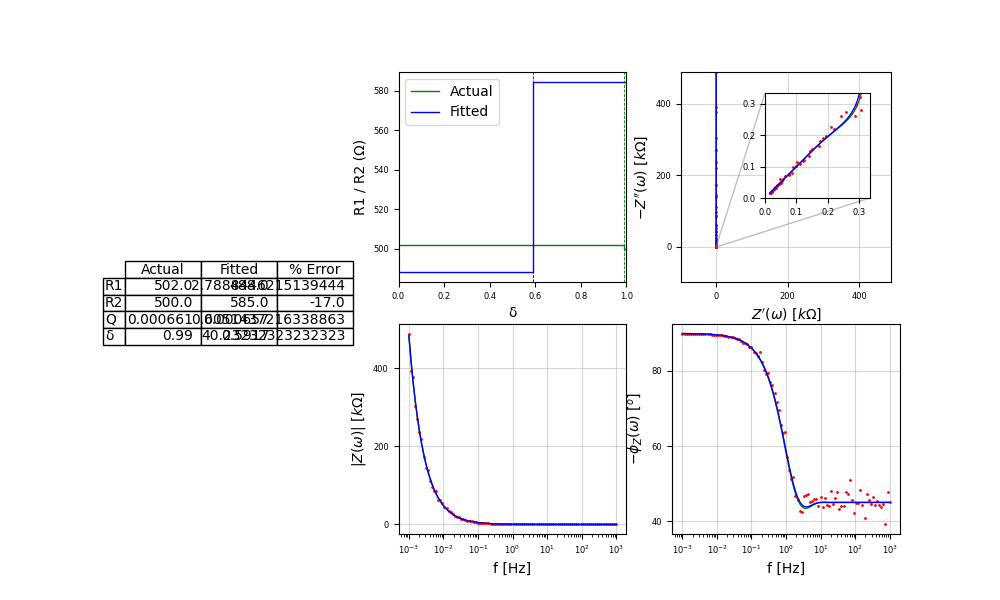

In [68]:
plt.close()
plotter_for_two(freq=freq,circuit0=c0,circuitg=cg,zin=z1,wt="prop")
plt.show()